<a href="https://colab.research.google.com/github/djliden/deep_learning_practice/blob/main/test_set_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
%%capture
!pip install --upgrade fastai
import PIL

In [2]:
import pandas as pd
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

df = pd.read_csv(path/'train.csv')

# Set up the initial training and validation set

We use the same approach as outlined in the book (ch6) -- nothing is different here.

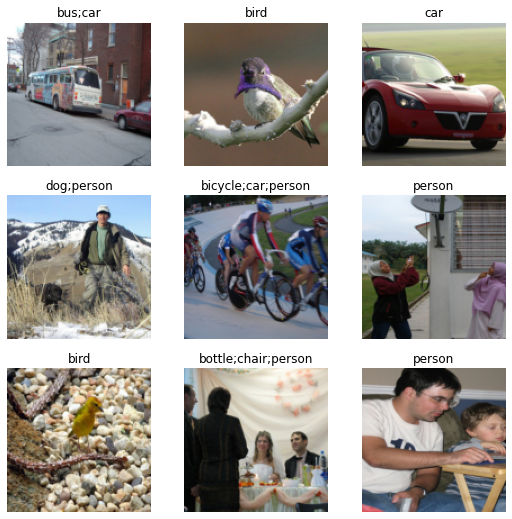

In [3]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')

def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x = get_x,
                   get_y = get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))

dls = dblock.dataloaders(df)
dls.show_batch()

# Define our metric and model

In [4]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when 'inp' and 'targ' are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

learn = cnn_learner(dls, resnet34, metrics=partial(accuracy_multi, thresh=0.2))
learn.metrics = partial(accuracy_multi, thresh=0.5)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


# Train the Model
Here we focus on getting a reasonably accurate model quickly without doing a any careful hyperparameter tuning.

In [6]:
learn.fine_tune(1, freeze_epochs=3) # just a few epochs because we're mostly interested in figuring out the test set.

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.536443,0.390531,0.889343,00:34
1,0.442703,0.219575,0.949721,00:34
2,0.302744,0.137365,0.955817,00:34


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.154688,0.124827,0.956594,00:35


# Evaluate a single test example

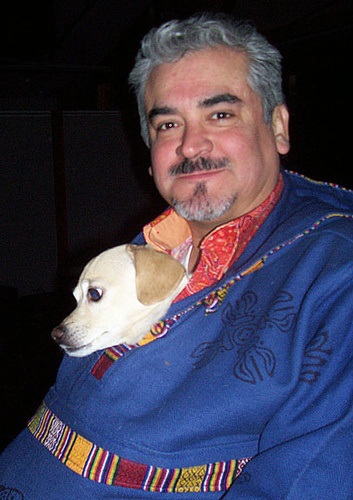

In [11]:
testdf = pd.read_csv(path/'test.csv')
single_test_example = PILImage.create((path/'test'/testdf.iloc[0,0]))
single_test_example

In [12]:
learn.predict(single_test_example)

((#2) ['dog','person'],
 tensor([False, False, False, False, False, False, False, False, False, False,
         False,  True, False, False,  True, False, False, False, False, False]),
 tensor([3.5505e-03, 3.2106e-03, 1.3396e-03, 7.8573e-04, 2.4324e-03, 2.0249e-03,
         4.0836e-04, 2.9097e-01, 2.4162e-02, 9.4763e-04, 1.6923e-03, 9.5470e-01,
         8.5849e-04, 2.6014e-03, 7.4462e-01, 3.6029e-03, 1.0673e-02, 8.4371e-02,
         1.2481e-03, 2.1200e-03]))

## A few notes
Our learner had some specific requirements for the type of input. This is to be expected, but I think it was obscured somewhat by the `DataLoader`, which does not make it immediately evident what exact data classes are accepted by the model. For example:

In [18]:
single_test_error = PIL.Image.open((path/'test'/testdf.iloc[0,0]))
learn.predict(single_test_error)

AssertionError: ignored

In [20]:
type(single_test_example), type(single_test_error)

(fastai.vision.core.PILImage, PIL.JpegImagePlugin.JpegImageFile)

# Get Predictions for Multiple Examples

In [45]:
test_dl = dls.test_dl(get_image_files(path/'test'))
preds, _ = learn.get_preds(dl = test_dl)

In [53]:
dls.train.vocab[torch.where((preds[0] > 0.5).int()==1.)]

(#1) ['diningtable']

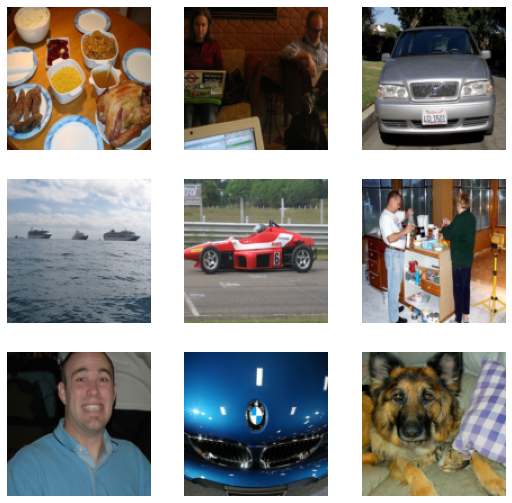

In [104]:
test_dl.show_batch()

I can see from `show_batch` that the prediction appears to have been correct. But I'm not sure how to just pull that single image. Or how to retrieve the filename, which would allow me to go back and reference the `dataframe` to obtain the label.

# Questions and Next Steps

- Clearly, one big problem is my lack of understanding of the various data types used by `fastai` and of how they interact with each other. `DataBlock` is doing a lot of work behind the scenes, and I'm finding it difficult to get the test data into a similar format that can be read by the learner.
- I've found matching labels to predictions manually to be challenging.
- Though I spent a while experimenting on this, I thus far have no idea how to get labels loaded into the test `dataloaders`. I know that it's possible as there is a `with_labels` argument to `test_dl`. But what format they need to be in or how to load them remains a mystery to me. See documentation [here](https://docs.fast.ai/data.core#Add-test-set-for-inference)
- I'm not clear on the distinction between `learn.predict` and `learn.get_preds`.